In [1]:
import sys 
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np 
import keras

module_path = str(Path.cwd().parents[0]/'Encoder')
if module_path not in sys.path:
    sys.path.append(module_path)

from Encoder import Encoder

file_path = "C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Coordinates_data\\Float_data_10000_events_fixedlen.csv"

In [2]:
def train_val_test_split(df):
    # np.split() to split the dataset
    # train_znorm.sample(frac=1, random_state=42) to shuffle the dataset random
    # [int(.6*len(train_znorm)),int(.8*len(train_znorm))] first split after 60% of the data. second split after 80%
    # 60% train set - 20% validation set - 20% test set
    df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)),int(.8*len(df))])
    return df_train, df_validate, df_test

def define_targets_and_features(df): 
    """Function defines the features and targets of a dataframe,
    The targets are in the last column of the dataframe; the features are in the other columns"""
    
    features, targets = df.keys()[0:-3], df.keys()[3:]
    return features, targets

In [3]:
df_data = pd.DataFrame(pd.read_csv(file_path))
print(df_data)
df_data = df_data.astype(int)

# Make train, validation and test split
df_train, df_validate, df_test = train_val_test_split(df_data)

# Store test to .csv file
df_test.to_csv("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Coordinates_data\\coords_fixed_length_testdata.csv")


# Define targets and features
features, targets = define_targets_and_features(df_data)
train_features = df_train[features]
train_targets = df_train[targets]
validate_features = df_validate[features]
validate_targets = df_validate[targets]

        0      1     2     3      4     5     6      7     8     9  ...  \
0     7.5  11.25  6.15  10.0  20.00  7.15  12.5  31.25  8.15  15.0  ...   
1     2.5   1.25  4.15   5.0   5.00  5.15   7.5  11.25  6.15  10.0  ...   
2     5.0   5.00  5.15   7.5  11.25  6.15  10.0  20.00  7.15  12.5  ...   
3     0.0   0.00  3.15   2.5   1.25  4.15   5.0   5.00  5.15   7.5  ...   
4     5.0   5.00  5.15   7.5  11.25  6.15  10.0  20.00  7.15  12.5  ...   
...   ...    ...   ...   ...    ...   ...   ...    ...   ...   ...  ...   
9995  2.5   1.25  4.15   5.0   5.00  5.15   7.5  11.25  6.15  10.0  ...   
9996  7.5  11.25  6.15  10.0  20.00  7.15  12.5  31.25  8.15  15.0  ...   
9997  5.0   5.00  5.15   7.5  11.25  6.15  10.0  20.00  7.15  12.5  ...   
9998  2.5   1.25  4.15   5.0   5.00  5.15   7.5  11.25  6.15  10.0  ...   
9999  7.5  11.25  6.15  10.0  20.00  7.15  12.5  31.25  8.15  15.0  ...   

         20    21      22     23    24      25     26    27      28     29  
0     12.15  25.0  125

In [4]:
d_model = int(512/4)
d_ff = 2048
batch_size = 64
h = 8 
n = 6
d_k = int(d_model/h)
d_v = int(d_model/h)
rate = 0.1

n_events = df_data.shape[0]
vocab_size = int(np.max(np.max(df_data), axis=0)+1) # add one because we include 0

padding_mask = None
seq_length = len(df_data.columns)+vocab_size
print(vocab_size)
print(seq_length)
print(d_k)


181
211
16


c:\Users\nvanb\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [5]:
df_data

0   1  2   3   4  5   6   7  8   9  ...  20  21   22  23  24   25  26  \
0     7  11  6  10  20  7  12  31  8  15  ...  12  25  125  13  27  151  14   
1     2   1  4   5   5  5   7  11  6  10  ...  10  20   80  11  22  101  12   
2     5   5  5   7  11  6  10  20  7  12  ...  11  22  101  12  25  125  13   
3     0   0  3   2   1  4   5   5  5   7  ...   9  17   61  10  20   80  11   
4     5   5  5   7  11  6  10  20  7  12  ...  11  22  101  12  25  125  13   
...  ..  .. ..  ..  .. ..  ..  .. ..  ..  ...  ..  ..  ...  ..  ..  ...  ..   
9995  2   1  4   5   5  5   7  11  6  10  ...  10  20   80  11  22  101  12   
9996  7  11  6  10  20  7  12  31  8  15  ...  12  25  125  13  27  151  14   
9997  5   5  5   7  11  6  10  20  7  12  ...  11  22  101  12  25  125  13   
9998  2   1  4   5   5  5   7  11  6  10  ...  10  20   80  11  22  101  12   
9999  7  11  6  10  20  7  12  31  8  15  ...  12  25  125  13  27  151  14   

      27   28  29  
0     30  180  15  
1     25  125  13  
2     27  151  14  
3     22  101  12  
4     27  151  14  
...   ..  ...  ..  
9995  25  125  13  
9996  30  180  15  
9997  27  151  14  
9998  25  125  13  
9999  30  180  15  

[10000 rows x 30 columns]

In [6]:
# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2)]

In [7]:
encoder_model = Encoder(batch_size, seq_length, h, n, d_model, d_ff, d_k, d_v, rate, vocab_size, d_model, padding_mask, training=True)
encoder_model.build(input_shape=(n_events, seq_length))
encoder_model.summary()

Tensor("position_embedding_fixed_weights/add:0", shape=(10000, 211, 128), dtype=float32)
Tensor("layer_normalization_1/add:0", shape=(10000, 211, 128), dtype=float32)
Tensor("layer_normalization_3/add:0", shape=(10000, 211, 128), dtype=float32)
Tensor("layer_normalization_5/add:0", shape=(10000, 211, 128), dtype=float32)
Tensor("layer_normalization_7/add:0", shape=(10000, 211, 128), dtype=float32)
Tensor("layer_normalization_9/add:0", shape=(10000, 211, 128), dtype=float32)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_fixed_we  multiple                 39552     
 ights (PositionEmbeddingFix                                     
 edWeights)                                                      
                                                                 
 encoder_layer (EncoderLayer  multiple                 0 (unused)
 )                                        

In [8]:
num_epochs = 5
encoder_model.compile(optimizer, loss=loss_function, metrics='accuracy')
history = encoder_model.fit(train_features, train_targets, batch_size=batch_size, epochs=num_epochs, validation_data=(validate_features, validate_targets), callbacks=callbacks)

encoder_model.save_weights("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Coordinates_data\\coords_model_fixedlen.keras")

Epoch 1/5
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0"

In [9]:
epoch_history = [_ for _ in range (0,num_epochs)]
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

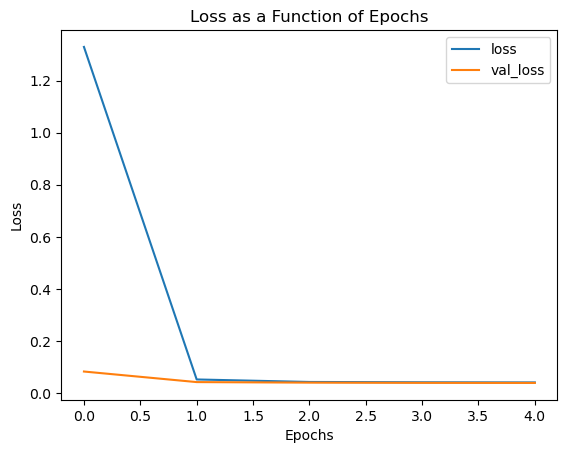

In [10]:
import matplotlib.pyplot as plt

plt.plot(epoch_history, loss_history, label='loss')
plt.plot(epoch_history, val_loss_history, label='val_loss')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predictions = encoder_model.predict(validate_features)
predicted_number = tf.argmax(predictions, axis=-1)

df_compare = pd.DataFrame()
df_compare['True x'] = validate_targets.iloc[:,-3:-2].reset_index(drop=True)
df_compare['Predicted x'] = predicted_number[:,-3]
df_compare['True y'] = validate_targets.iloc[:,-2:-1].reset_index(drop=True)
df_compare['Predicted y'] = predicted_number[:,-2]
df_compare['True z'] = validate_targets.iloc[:,-1:].reset_index(drop=True)
df_compare['Predicted z'] = predicted_number[:,-1]
df_compare['Difference in x'] = df_compare['True x'] - df_compare['Predicted x']
df_compare['Difference in y'] = df_compare['True y'] - df_compare['Predicted y']
df_compare['Difference in z'] = df_compare['True z'] - df_compare['Predicted z']

x_higher_locs = np.where(df_compare['Difference in x'] > 0)
x_lower_locs = np.where(df_compare['Difference in x'] < 0)
x_wrong_locs = np.where(df_compare['Difference in x'] != 0)
y_higher_locs = np.where(df_compare['Difference in y'] > 0)
y_lower_locs = np.where(df_compare['Difference in y'] < 0)
y_wrong_locs = np.where(df_compare['Difference in y'] != 0)
z_higher_locs = np.where(df_compare['Difference in z'] > 0)
z_lower_locs = np.where(df_compare['Difference in z'] < 0)
z_wrong_locs = np.where(df_compare['Difference in z'] != 0)

print('percentage te hoog geschat x: ', 100*len(x_higher_locs[0])/len(validate_features), '%')
print('percentage te laag geschat x: ', 100*len(x_lower_locs[0])/len(validate_features), '%')
print('percentage verkeerd geschat x: ', 100*len(x_wrong_locs[0])/len(validate_features), '%')

print('percentage te hoog geschat y: ', 100*len(y_higher_locs[0])/len(validate_features), '%')
print('percentage te laag geschat y: ', 100*len(y_lower_locs[0])/len(validate_features), '%')
print('percentage verkeerd geschat y: ', 100*len(y_wrong_locs[0])/len(validate_features), '%')

print('percentage te hoog geschat z: ', 100*len(z_higher_locs[0])/len(validate_features), '%')
print('percentage te laag geschat z: ', 100*len(z_lower_locs[0])/len(validate_features), '%')
print('percentage verkeerd geschat z: ', 100*len(z_wrong_locs[0])/len(validate_features), '%')

Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 27, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(None, 27, 128), dtype=float32)
63/63 [==============================] - 6s 77ms/step
percentage te hoog geschat x:  0.0 %
percentage te laag geschat x:  0.0 %
percentage verkeerd geschat x:  0.0 %
percentage te hoog geschat y:  0.0 %
percentage te laag geschat y:  0.0 %
percentage verkeerd geschat y:  0.0 %
percentage te hoog geschat z:  0.0 %
percentage te laag geschat z:  0.0 %
percentage verkeerd geschat z:  0.0 %


In [12]:
df_compare

True x  Predicted x  True y  Predicted y  True z  Predicted z  \
0         27           27     151          151      14           14   
1         30           30     180          180      15           15   
2         27           27     151          151      14           14   
3         27           27     151          151      14           14   
4         25           25     125          125      13           13   
...      ...          ...     ...          ...     ...          ...   
1995      22           22     101          101      12           12   
1996      22           22     101          101      12           12   
1997      25           25     125          125      13           13   
1998      30           30     180          180      15           15   
1999      22           22     101          101      12           12   

      Difference in x  Difference in y  Difference in z  
0                   0                0                0  
1                   0                0                0  
2                   0                0                0  
3                   0                0                0  
4                   0                0                0  
...               ...              ...              ...  
1995                0                0                0  
1996                0                0                0  
1997                0                0                0  
1998                0                0                0  
1999                0                0                0  

[2000 rows x 9 columns]